# Import necessary libraries

In [1]:
import math
import cv2
import os
import sys
import numpy as np
import json
import IPython.display as IPD

# Loading DataSet
The function takes in a file path to a dataset in JSON format and uses the json library to load it into a variable called data it then returns the variable

In [2]:
def loadDataSet(file_path: str):
    # Open the file in read-only mode
    f = open(file_path, 'r')
    # Load the contents of the file as JSON data
    data = json.load(f)
    # Return the loaded data
    return data

# Normalizing Image
The function takes an image as input and performs a series of image processing operations to enhance its details and improve contrast. It converts the image to grayscale, applies dilation and median blur operations to each plane of the grayscale image, computes the absolute difference between the plane and the blurred image, normalizes the difference image to the range of 0-255, and merges the normalized planes back into a single image. The function then returns the normalized image.

In [3]:
def NormalizeImage(img):
    # Convert the image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Split the grayscale image into separate planes
    rgbPlanes = cv2.split(gray)

    normalizedPlanes = []
    for plane in rgbPlanes:
        # Dilate the plane using a 7x7 kernel
        dilatedImage = cv2.dilate(plane, np.ones((7, 7), np.uint8))

        # Apply median blur with a kernel size of 21
        blurredImage = cv2.medianBlur(dilatedImage, 21)

        # Compute the absolute difference between the plane and the blurred image
        planeDifferenceImage = 255 - cv2.absdiff(plane, blurredImage)

        # Normalize the difference image to the range of 0-255
        normalizedImage = cv2.normalize(planeDifferenceImage, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX,
                                        dtype=cv2.CV_8UC1)

        # Append the normalized plane to the list of normalized planes
        normalizedPlanes.append(normalizedImage)

    # Merge the normalized planes back into a single image
    normalizedResult = cv2.merge(normalizedPlanes)

    return normalizedResult

# Extracting Features
The function takes an image as input and uses the SIFT algorithm to detect key points and compute descriptors. The function first creates a SIFT object for feature extraction. It then attempts to convert the image to grayscale using the OpenCV function cv2.cvtColor. If the conversion is successful, it detects and computes key points and descriptors using SIFT on the grayscale image. If the conversion fails, it assumes that the image is already in grayscale and directly applies the SIFT algorithm on the original image. In either case, the function returns the detected key points and descriptors.

In [4]:
def ExtractFeatures(img):
    # Create a SIFT object for feature extraction
    sift = cv2.SIFT_create()

    try:
        # Try converting the image to grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    except:
        # If conversion fails, assume the image is already grayscale
        # Detect and compute key points and descriptors using SIFT
        keyPoints, descriptors = sift.detectAndCompute(img, None)
        return keyPoints, descriptors

    # Detect and compute key points and descriptors using SIFT
    # Return the detected key points and descriptors
    keyPoints, descriptors = sift.detectAndCompute(gray, None)
    return keyPoints, descriptors

# Matching Features
The function takes two images as input and performs feature matching between them using the brute-force matching algorithm. It extracts features from both images, matches descriptors between the images, filters out ambiguous matches using a ratio test, computes similarity scores based on match distances, and normalizes the scores. 

In [5]:
def MatchFeatures(img1, img2, v=False, imgReal=None):
    try:
        # Create a brute-force matcher
        bruteForceMatcher = cv2.BFMatcher()

        # Extract features (key points and descriptors) from both images
        keyPoints1, descriptors1 = ExtractFeatures(img1)
        keyPoints2, descriptors2 = ExtractFeatures(img2)

        # Perform matching of descriptors between the two images
        matches = bruteForceMatcher.knnMatch(descriptors1, descriptors2, k=2)

        # Perform ratio test to filter out ambiguous matches
        optimizedMatches = []
        for firstImageMatch, secondImageMatch in matches:
            if firstImageMatch.distance < 1 * secondImageMatch.distance:
                optimizedMatches.append(firstImageMatch)

        # Compute similarity scores based on match distances
        similarity_scores = [match.distance for match in optimizedMatches]
        max_distance = max(similarity_scores)
        min_distance = min(similarity_scores)
        normalized_scores = [(max_distance - score) / ((max_distance - min_distance) + 0.0000001) for score in
                             similarity_scores]

        if v:
            # Display the matched image (if enabled)
            matched_image = cv2.drawMatches(img1, keyPoints1, imgReal, keyPoints2, optimizedMatches, None,
                                        flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
            OutImg = cv2.imencode('.png', matched_image)[1]
            IPD.display(IPD.Image(OutImg))

        # Compute the average normalized score as a measure of similarity
        return sum(normalized_scores) / len(normalized_scores)
    except:
        # Return infinity if an exception occurs during the process
        return math.inf

# Testing All Images and Computing Accuracy
The functions computes total accuarcy for all boxes in the images in testImages directory

In [6]:
def testImages(v=False):
    # Load the dataset file
    print("Loading DataSet File..")
    dataSet = loadDataSet('training.json')
    print("DataSet File Loaded!!\n")
    accuracy = []
    total = len(os.listdir("testImages"))
    i = 0
    for filename in os.listdir("testImages"):
        i += 1
        loadPercent = (i / total) * 100
        if not v:
            sys.stdout.write(
                f"\rComputing Accuracy: [{'=' * math.floor(loadPercent / 10)}{' ' * (10 - math.floor(loadPercent / 10))}]"
                f"{round(loadPercent, 1)}%")

        # Read the real image
        imgReal = cv2.imread(os.path.join("testImages", filename))
        # Get the bounding boxes for the current image
        boxes = dataSet[int(filename.split(".")[0]) - 1]['boxes']
        # Normalize the real image
        normalizedImage = NormalizeImage(imgReal)

        for idxBox, box in enumerate(boxes):
            # Extract the region of interest (ROI) from the real image based on the bounding box
            (x, y, w, h) = int(box['left']), int(box['top']), int(box['width']), int(box['height'])
            img = imgReal[y:y+h, x:x+w]
            # Extract the label and initialize the predicted digit
            label = str(box['label']).split(".")[0]
            digit = ""
            score = math.inf
            for idx, digitFilename in enumerate(os.listdir("digitTemplates")):
                # Load the digit template image
                template = os.path.join("digitTemplates", digitFilename)
                digitTemplate = cv2.imread(template)

                # Resize the digit template to match the size of the ROI
                desired_height = img.shape[0]
                aspect_ratio = digitTemplate.shape[1] / digitTemplate.shape[0]
                desired_width = int(desired_height * aspect_ratio)
                resized_image = cv2.resize(digitTemplate, (desired_width, desired_height))

                # Match features between the resized digit template and the normalized ROI
                sim = MatchFeatures(resized_image, normalizedImage[y:y+h, x:x+w], v)
                if sim < score:
                    # Update the predicted digit if a better match is found
                    score = sim
                    digit = digitFilename.split(".")[0]

            if v:
                # Display the predicted digit on the ROI image (if enabled)
                image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                aspect_ratio = image.shape[1] / image.shape[0]
                image = cv2.resize(image, (int(500 * aspect_ratio), 500))
                image = cv2.putText(image, digit, (image.shape[1] // 2, image.shape[0] // 2), cv2.FONT_HERSHEY_SIMPLEX,
                                    3, (0, 255, 0), 5, cv2.LINE_AA)
                cv2.imshow('Digit', image)
                cv2.waitKey(0)
                cv2.destroyAllWindows()
                print(f"\nImage {filename.split('.')[0]}, Box:{idxBox}: Label = {label},"
                      f" Predicted Outcome = {digit}")

            # Compute the accuracy by comparing the predicted digit with the label
            accuracy.append(digit == label)

    if not v:
        sys.stdout.write(f"\rComputing Accuracy: [{'=' * 10}] 100%")
    return sum(accuracy)/len(accuracy)

# Testing Specific Images

In [7]:
def TestImage(filename):
    dataSet = loadDataSet('training.json')
    imgReal = cv2.imread(os.path.join("RecognitionTestImages", filename))
    boxes = dataSet[int(filename.split(".")[0]) - 1]['boxes']
    normalizedImage = NormalizeImage(imgReal)
    for idxBox, box in enumerate(boxes):
        (x, y, w, h) = int(box['left']), int(box['top']), int(box['width']), int(box['height'])
        img = imgReal[y:y+h, x:x+w]
        digit = ""
        score = math.inf
        for idx, digitFilename in enumerate(os.listdir("digitTemplates")):
            template = os.path.join("digitTemplates", digitFilename)
            digitTemplate = cv2.imread(template)
            aspect_ratio = digitTemplate.shape[1] / digitTemplate.shape[0]
            resized_image = cv2.resize(digitTemplate, (int(h * aspect_ratio), int(h)))
            sim = MatchFeatures(resized_image, normalizedImage[y:y+h, x:x+w], True, img)
            if sim < score:
                score = sim
                digit = digitFilename.split(".")[0]
                
        aspect_ratio = h / w
        image = cv2.resize(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), (int(250 * aspect_ratio), 250))
        image = cv2.putText(image, digit, (w // 2, h // 2), cv2.FONT_HERSHEY_SIMPLEX,
                            2, (0, 255, 0), 5, cv2.LINE_AA)
        OutImg = cv2.imencode('.png', image)[1]
        IPD.display(IPD.Image(OutImg))

# Test Output

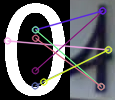

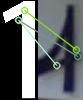

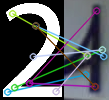

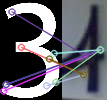

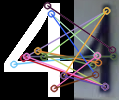

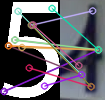

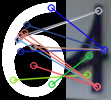

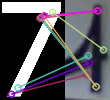

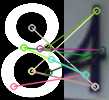

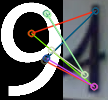

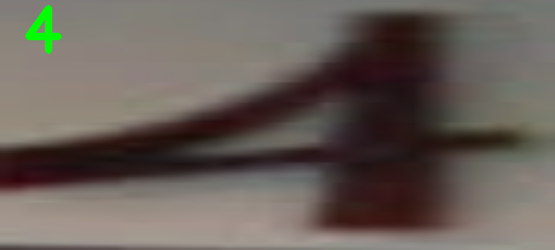

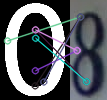

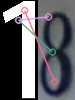

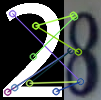

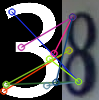

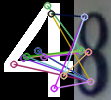

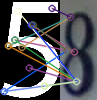

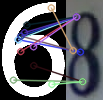

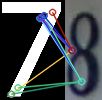

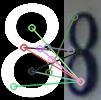

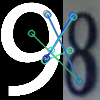

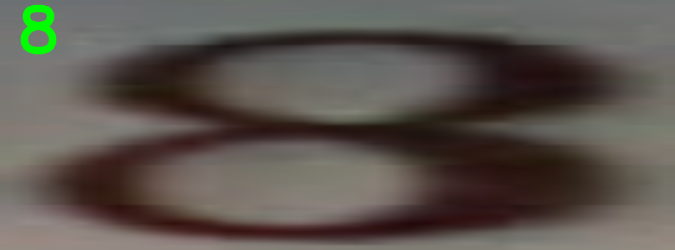

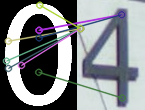

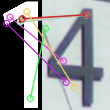

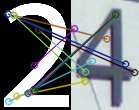

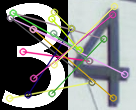

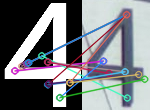

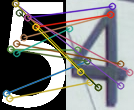

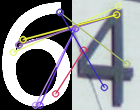

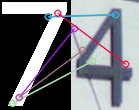

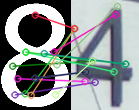

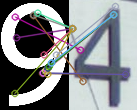

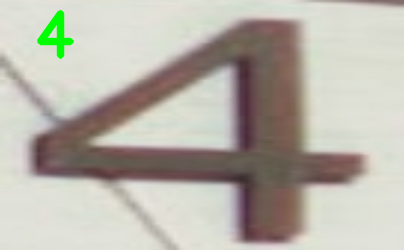

In [8]:
TestImage('1396.png')
TestImage('1748.png')

# Compute Accuracy

In [9]:
acc = testImages()
print(f"\n\nAccuracy: {round(acc * 100, 1)}%")

Loading DataSet File..
DataSet File Loaded!!

Computing Accuracy: [==========] 100%%

Accuracy: 7.8%
